In [1]:
import numpy as np
import matplotlib.pyplot as plt

def histParam_kin(p_names,names,data,filename):
    for name in p_names:
        var_names = ["px","py","pz"]
        data_mom = data[names == name,5:]
        for j, var_name in enumerate(var_names):
            plt.figure()
            plt.hist(data_mom[:,j], bins=100)
            plt.xlabel(f'{var_name} (keV)')
            plt.ylabel('Counts')
            #plt.yscale('log')
            plt.title(name)
            plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')
        data_E = data[names == name,4]
        data_v = data_mom/data_E[:,np.newaxis]
        var_names2 = ["vx","vy","vz"]
        for j, var_name in enumerate(var_names2):
            plt.figure()
            plt.hist(data_v[:,j], bins=100)
            plt.xlabel(f'{var_name} (c)')
            plt.ylabel('Counts')
            #plt.yscale('log')
            plt.title(name)
            plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')
        if name in ['e+','e-']:
            data_dir = data_v/np.tile(np.linalg.norm(data_v,axis=1),(3,1)).T
            var_names3 = ["x_dir","y_dir","z_dir"]
            for j, var_name in enumerate(var_names3):
                plt.figure()
                plt.hist(data_dir[:,j], bins=100)
                plt.xlabel(f'{var_name}')
                plt.ylabel('Counts')
                #plt.yscale('log')
                plt.title(name)
                plt.savefig(f'plots/{filename[6:-4]}_{name}_{var_name}.pdf')

    chargedl_data = data[np.logical_or(names == 'e+',names == 'e-'),5:8]
    neutrino_data = data[np.logical_or(names == 'enu',names == 'enubar'),5:8]
    chargedl_data = chargedl_data/np.tile(np.linalg.norm(chargedl_data,axis=1),(3,1)).T
    neutrino_data = neutrino_data/np.tile(np.linalg.norm(neutrino_data,axis=1),(3,1)).T
    angle = np.sum(chargedl_data*neutrino_data,axis=1)
    plt.figure()
    plt.hist(angle, bins=100)
    plt.xlabel('cos(theta_{e,enu})')
    plt.ylabel('Counts')
    #plt.yscale('log')
    plt.savefig(f'plots/{filename[6:-4]}_angular_correlation_enu_e.pdf')

In [2]:
mass_e = 510.9989461

class data_analysis:
    def __init__(self,fileName,betaType):
        data = np.genfromtxt(fileName, dtype=str)
        self.names = data[:,2]
        self.data = data[:, np.arange(data.shape[1]) != 2].astype(dtype=np.float32)
        self.events = data[:,0].astype(int)
        self.data[np.isnan(self.data)] = 0
        self.c_lepton = "e-" if (betaType == 1) else "e+"
        self.neutrino = "enubar" if (betaType == 1) else "enu"
    def __len__(self):
        return self.data.shape[0]
    def event_mask(self):
        pass
    def kinematical_data(self):
        #energy
        self.data_E_el = self.data[self.names == self.c_lepton ,4]
        
        #directions
        self.data_dir_el = self.data[self.names == self.c_lepton ,5:8]
        self.data_dir_el /= np.tile(np.linalg.norm(self.data_dir_el,axis=1),(3,1)).T
        self.data_dir_enu = self.data[self.names == self.neutrino ,5:8]
        self.data_dir_enu /= np.tile(np.linalg.norm(self.data_dir_enu,axis=1),(3,1)).T
        
        #angle between e and enu
        self.data_angle_elenu = np.sum(self.data_dir_el*self.data_dir_enu,axis=1)
     
    def kinematical_data_ref(self,polDir = np.array([0,0,1])):
        #angles in reference to polDir
        z_cross_elenu = np.sum(np.cross(self.data_dir_el,self.data_dir_enu)*polDir[np.newaxis,:],axis=1)
        self.cos_el = np.sum(self.data_dir_el*polDir[np.newaxis,:],axis=1)
        self.cos_enu = np.sum(self.data_dir_enu*polDir[np.newaxis,:],axis=1)
        sin_el = np.sqrt(1-self.cos_el**2)
        sin_enu = np.sqrt(1-self.cos_enu**2)
        data_cosphi = (self.data_angle_elenu-self.cos_el*self.cos_enu)/sin_el/sin_enu
        data_sinphi = z_cross_elenu/sin_el/sin_enu
        self.data_phi = np.arctan2(data_sinphi,data_cosphi)
    def plot_E_dist(self):
        print(self.data_E_el.size)
        plt.hist(self.data_E_el, bins=100)
        plt.xlabel('E')
        plt.ylabel('Counts')
        #plt.yscale('log')
        plt.title("e-")
        plt.show()
    def theoretical_dist(self, coeffs):
        #note a, c, A, B and D need to be functions dependent on energy
        E_hist, E_bin = np.histogram(self.data_E_el, bins= 200)
        E_vals = (E_bin[1:]+E_bin[:-1])/2
        N = self.data_E_el.size

        z_el = np.linspace(-1,1,201)
        z_nu = z_el.copy()
        z_elenu = z_el.copy()
        phi = np.linspace(-np.pi,np.pi,501)

        self.z_el = z_el
        self.z_nu = z_nu
        self.z_elenu = z_elenu
        self.phi = phi
        
        self.z_el_theory = np.zeros_like(z_el)
        self.z_nu_theory = np.zeros_like(z_nu)
        self.z_elenu_theory = np.zeros_like(z_elenu)
        self.phi_theory = np.zeros_like(phi)

        for E, dist in zip(E_vals, E_hist):
            a, b, c, A, B, D = coeffs(E)
            beta = np.sqrt(1-mass_e**2/E**2)
            self.z_el_theory += dist/N*(1+b*mass_e/E+A*beta*z_el)/2/(1+b*mass_e/E) 
            self.z_elenu_theory += dist/N*(1+b*mass_e/E+a*beta*z_elenu)/2/(1+b*mass_e/E)
            self.z_nu_theory += dist/N*(1+b*mass_e/E+B*z_nu)/2/(1+b*mass_e/E)
            phi_theory_E = dist/N*(1 + b*mass_e/E + beta*((a+c/3)*np.cos(phi)+D*np.sin(phi))*(np.pi/4)**2)
            self.phi_theory += phi_theory_E/2/np.pi/(1+b*mass_e/E)

    def plot_kin_histograms(self,fileName):
        p_names = (set(self.names)&{'e+','e-','enubar','enu'})
        histParam_kin(p_names,self.names,self.data,fileName)
        plt.show()
    def plot_distribution_histograms(self,showTheory,bins=100):
        plt.hist(self.cos_el, bins=bins,density=True) #z component
        if showTheory:
            plt.plot(self.z_el,self.z_el_theory)
        plt.xlabel("$\\cos \\theta_{e,j}$")
        plt.ylabel('pdf')
        #plt.yscale('log')
        plt.show()
        plt.hist(self.cos_enu, bins=bins,density=True) #z component
        if showTheory: 
            plt.plot(self.z_nu,self.z_nu_theory)
        plt.xlabel("$\\cos \\theta_{\\nu,j}$")
        plt.ylabel('pdf')
        #plt.yscale('log')
        plt.show()
        plt.hist(self.data_angle_elenu, bins=bins,density=True)
        if showTheory: 
            plt.plot(self.z_elenu,self.z_elenu_theory)
        plt.xlabel("$\\cos \\theta_{e,\\nu}$")
        plt.ylabel('pdf')
        #plt.yscale('log')
        plt.show()
        plt.hist(self.data_phi, bins=bins,density=True)
        if showTheory: 
            plt.plot(self.phi,self.phi_theory)
        plt.xlabel("$\\phi$")
        plt.ylabel('pdf')
        #plt.yscale('log')
        plt.show()

In [16]:
mu_60Co = 3.799*3.152451e-8 #ev.T^-1
kb = 8.617e-5 #ev.K^-1
B = 1 #T

T = np.linspace(0.002,0.02,10)

mj_states = np.arange(-5,6)

p_states = np.exp(mu_60Co*B*mj_states[:,np.newaxis]/kb/T[np.newaxis,:])
print(p_states.shape)
Z = p_states.sum(axis=0)
print(Z.shape)
p_states /= Z[np.newaxis,:]
for i in range(10):
    print(p_states[:,i])
    print(p_states.sum(axis=0))

polz_list = np.sum(p_states*mj_states[:,np.newaxis]/5,axis=0)
Jzz = np.sum(p_states*mj_states[:,np.newaxis]**2,axis=0)
align_list = (3*Jzz-5*6)/5/9

print(polz_list)
print(align_list)

p_states_ext = np.exp(mu_60Co*B*mj_states/kb/0.002)
Z_ext = p_states_ext.sum()
p_states_ext /= Z_ext
polz_ext = np.sum(p_states_ext*mj_states)/5
Jzz_ext = np.sum(p_states_ext*mj_states**2)
align_ext = (3*Jzz_ext-5*6)/5/9
print(p_states_ext,polz_ext,Jzz_ext,align_ext)

(11, 10)
(10,)
[4.80803679e-04 9.63308600e-04 1.93002570e-03 3.86688047e-03
 7.74744324e-03 1.55222995e-02 3.10995219e-02 6.23090842e-02
 1.24838638e-01 2.50118997e-01 5.01122997e-01]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.00929513 0.01315693 0.01862316 0.02636041 0.03731221 0.05281408
 0.07475644 0.10581504 0.14977738 0.21200449 0.30008473]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.02212429 0.02789129 0.03516154 0.04432687 0.05588128 0.07044749
 0.08881059 0.11196028 0.14114425 0.17793542 0.22431671]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.03293999 0.03918979 0.04662537 0.05547173 0.06599654 0.07851824
 0.09341572 0.11113974 0.13222659 0.1573143  0.18716198]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.04127237 0.04742626 0.05449773 0.06262359 0.07196105 0.08269077
 0.09502033 0.10918829 0.12546876 0.14417672 0.16567412]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.04768352 0.05353871 0.06011288 0.0674943  0.07578212 0.08508761
 0.09553576 0.10726686 0.12043845 0.13522742 0.15183237]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.0

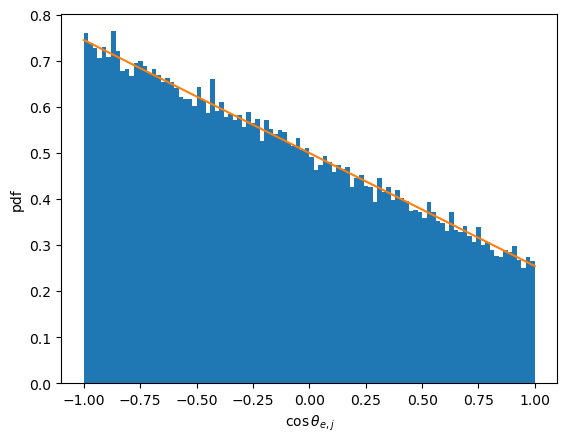

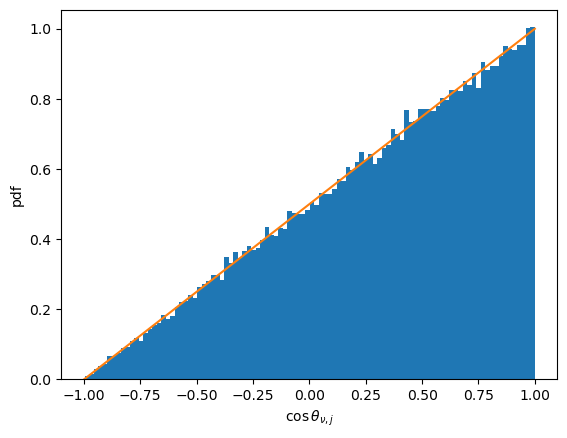

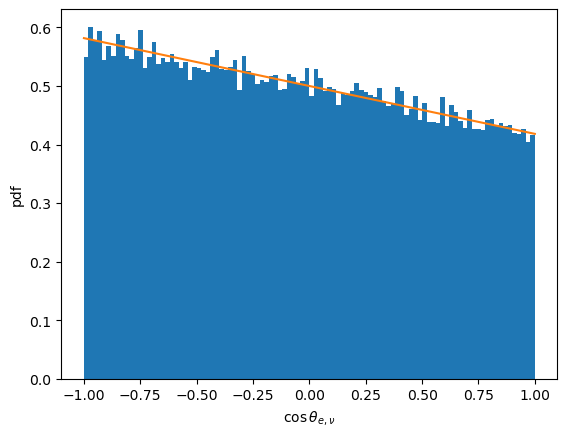

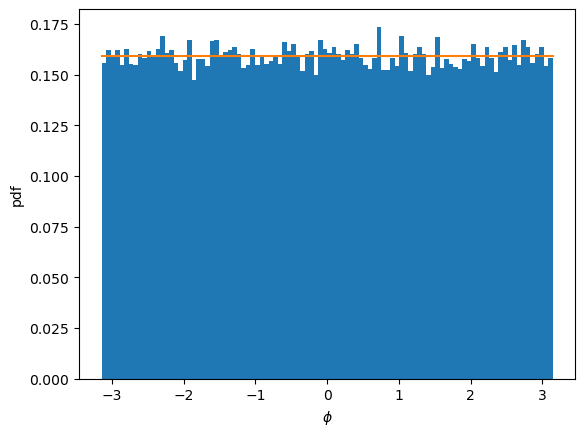

In [3]:
class Co60_data_analysis(data_analysis):
    def __init__(self, fileName):
        super().__init__(fileName, 1)
    def event_mask(self):
        part_events = np.bincount(self.events)
        events_mask = np.arange(part_events.size)[part_events == 5] #60Ni + e- + enu + 2 gamma
        self.data = self.data[np.isin(self.events, events_mask),:]
        self.names = self.names[np.isin(self.events, events_mask)]
    
#Standard Model Gamov-Teller

def SM_coeffs(E):
    return (-1/3, 0, 1, -1, 1, 0)
   
SM_60Co_polZpos = Co60_data_analysis("build/60Co_polZpos.txt")
SM_60Co_polZpos.event_mask()
SM_60Co_polZpos.kinematical_data()
SM_60Co_polZpos.kinematical_data_ref()
SM_60Co_polZpos.theoretical_dist(SM_coeffs)
SM_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100)

0 0.002 0.4991169800391592 0.8017592091689112 0.5334587142643609


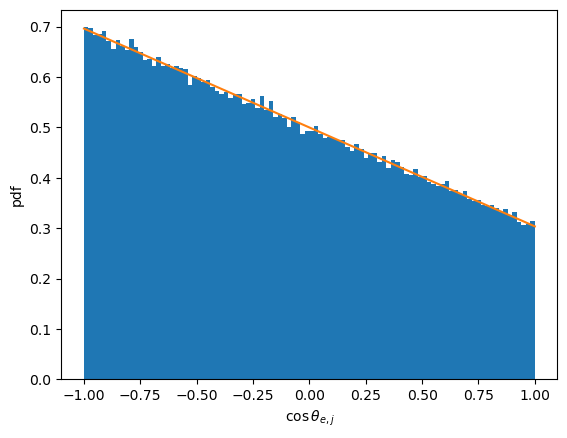

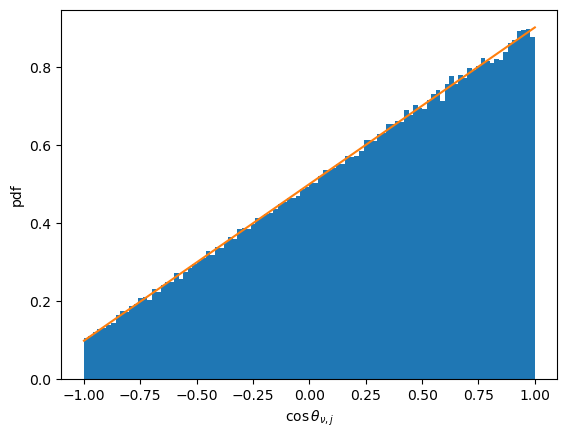

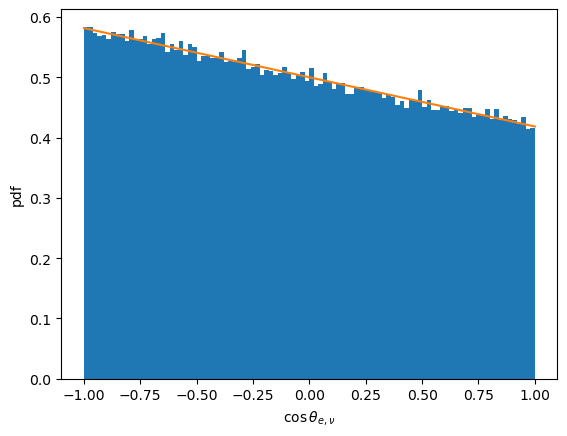

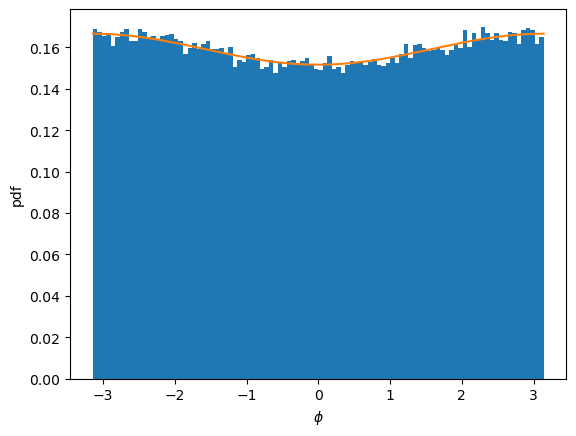

1 0.004 0.7064821158664664 0.5678308882594791 0.2328969737660742


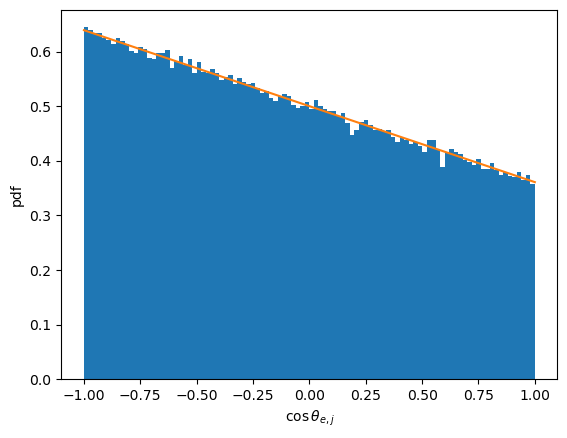

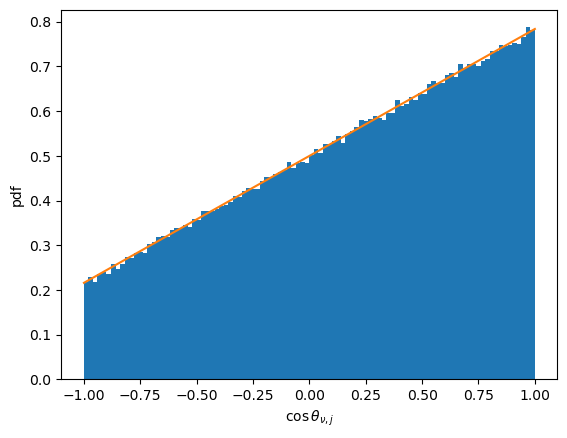

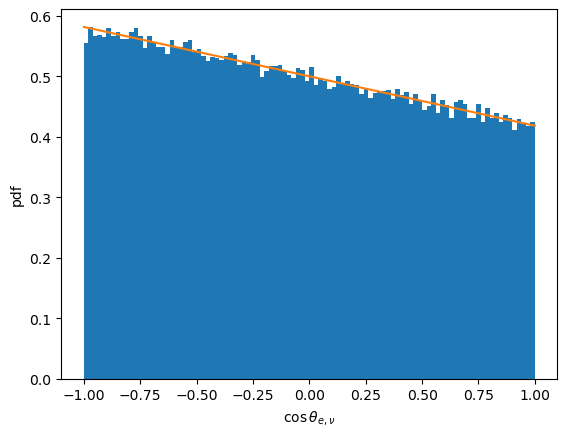

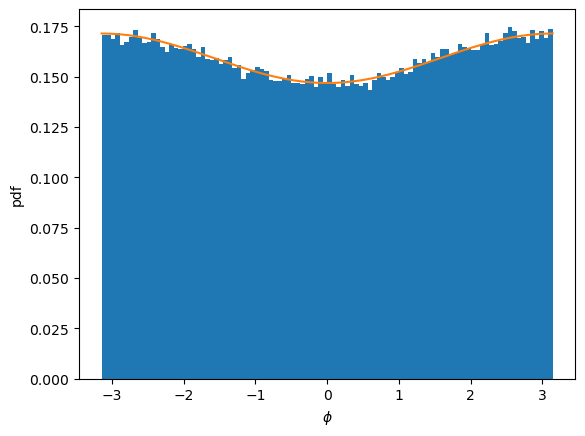

2 0.006 0.7932330150567591 0.4194565596004953 0.12072299443064449


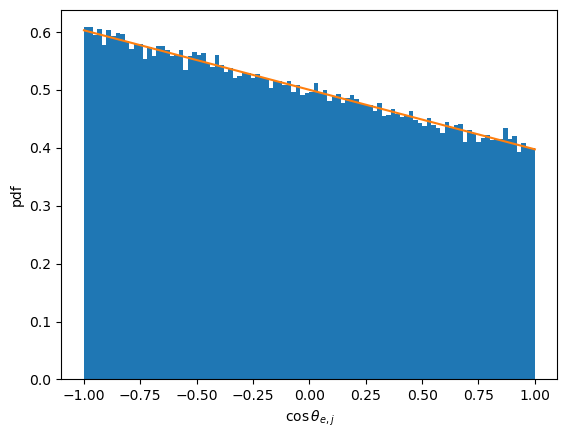

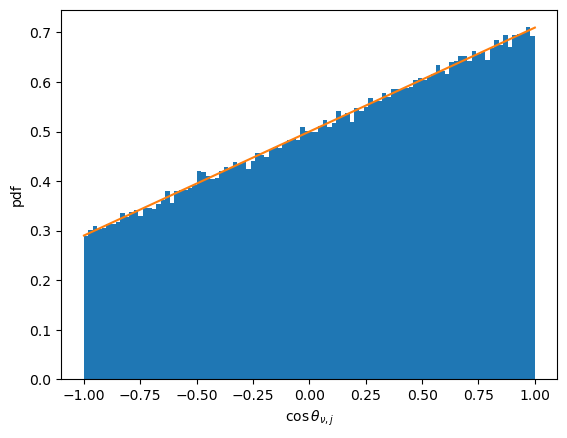

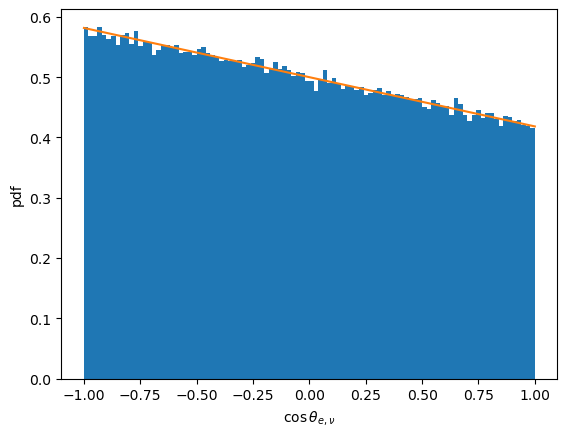

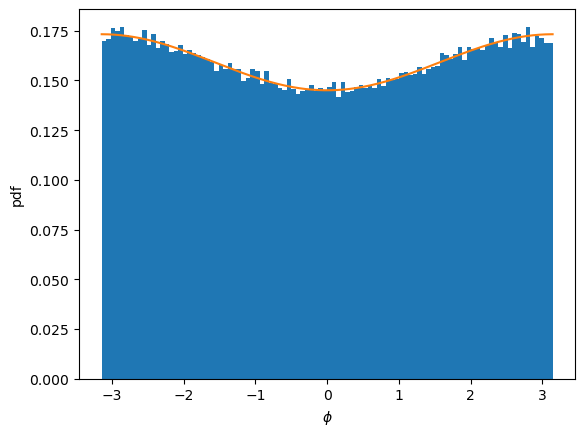

3 0.008 0.8405249049650262 0.32783337220627184 0.07214270438907372


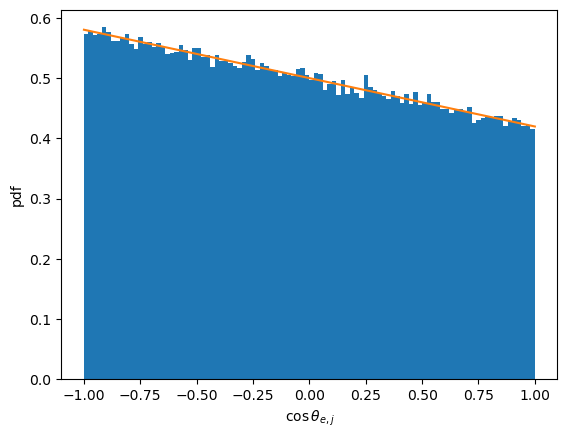

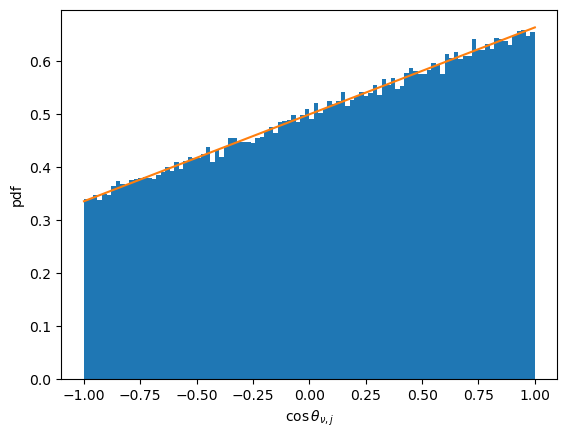

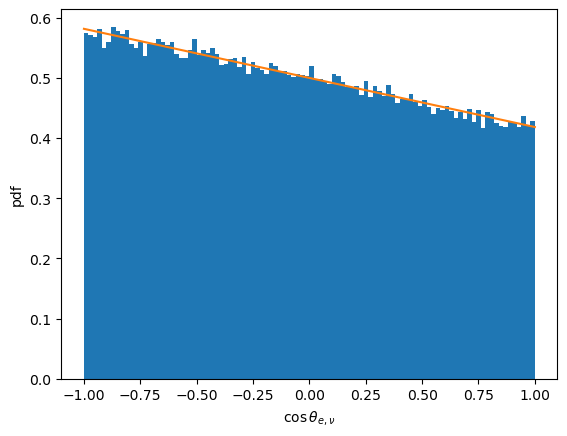

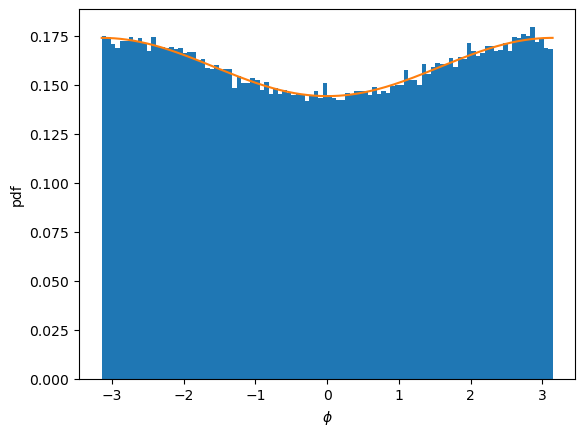

4 0.01 0.8702428604433473 0.26762247983601306 0.04754915242019548


/tmp/ipykernel_422760/781026101.py:36: RuntimeWarning: divide by zero encountered in divide
  data_cosphi = (self.data_angle_elenu-self.cos_el*self.cos_enu)/sin_el/sin_enu
/tmp/ipykernel_422760/781026101.py:37: RuntimeWarning: divide by zero encountered in divide
  data_sinphi = z_cross_elenu/sin_el/sin_enu


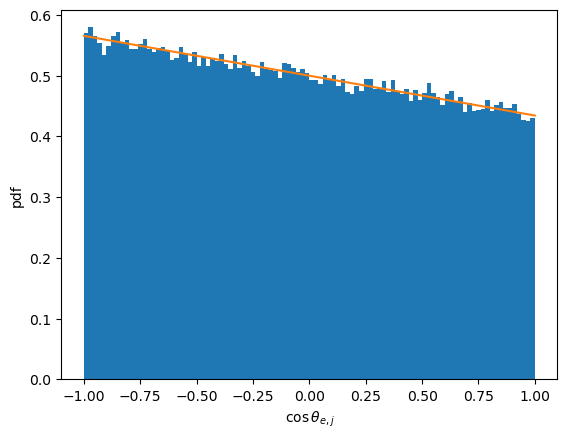

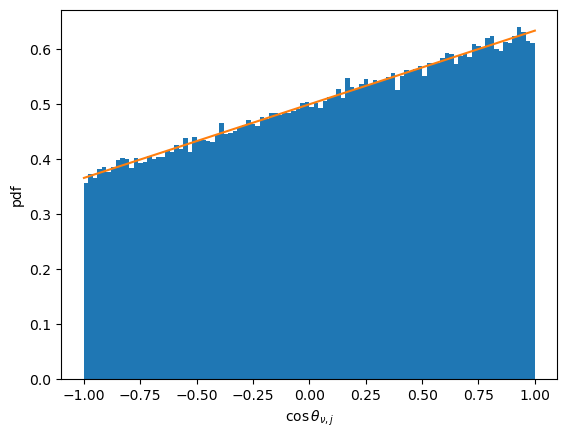

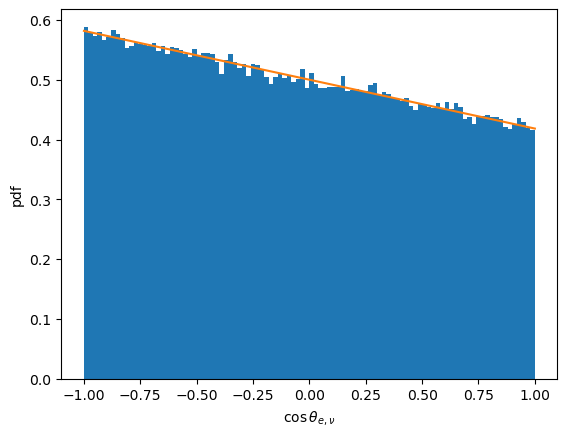

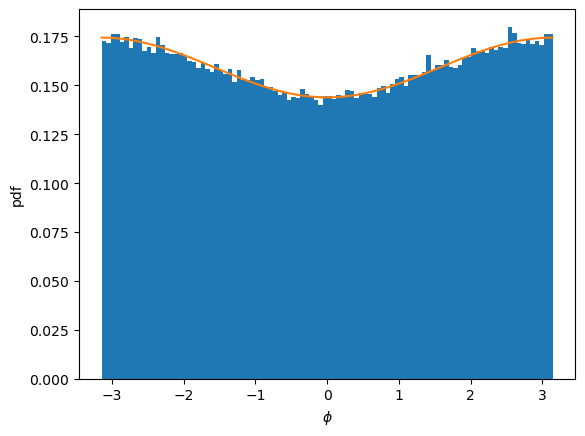

5 0.012 0.8906362978549432 0.22555492214454892 0.033565328038153396


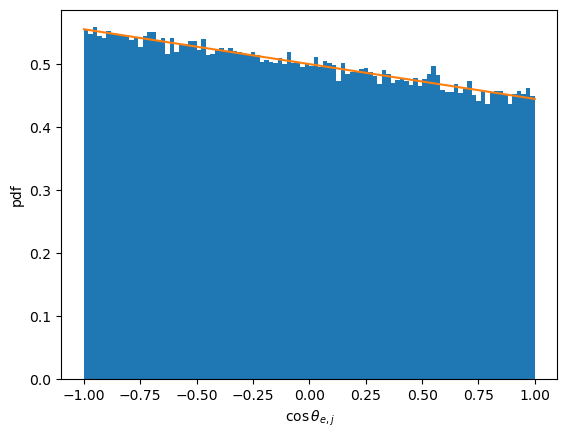

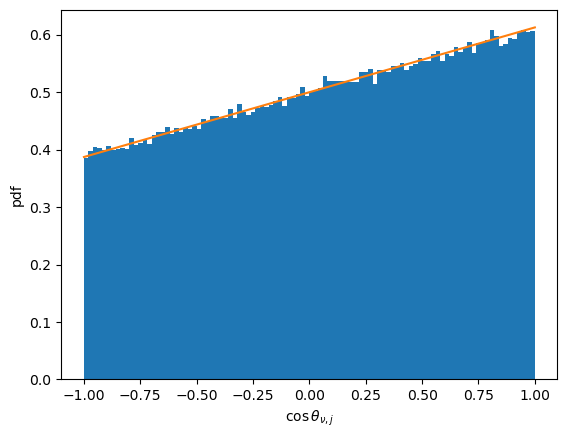

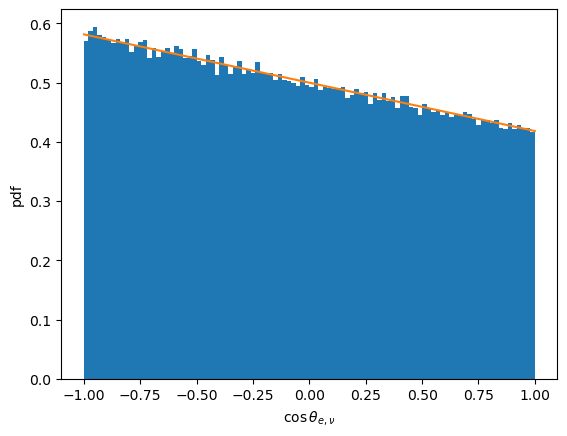

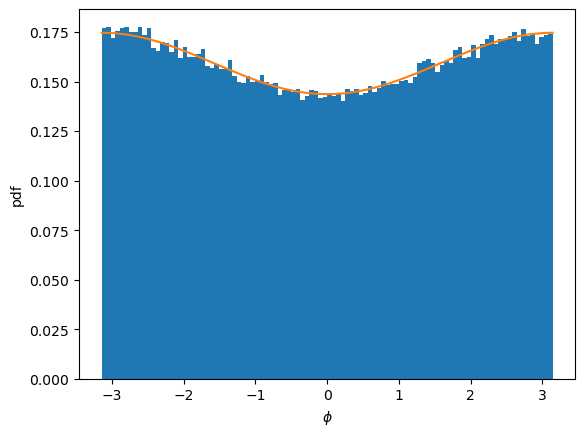

6 0.014 0.9054949848170326 0.1946781023579313 0.024908424247687026


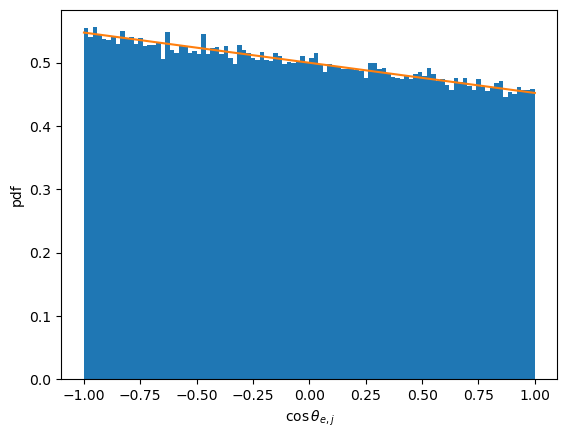

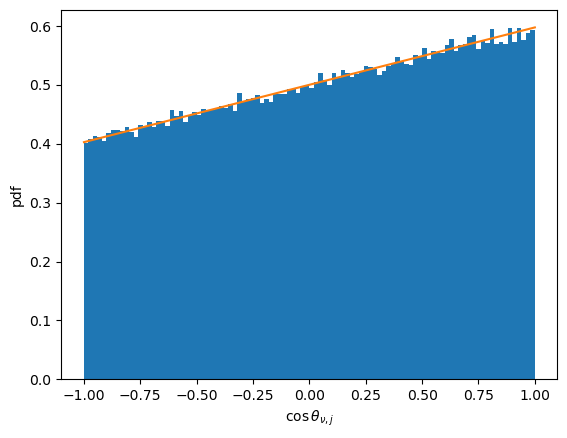

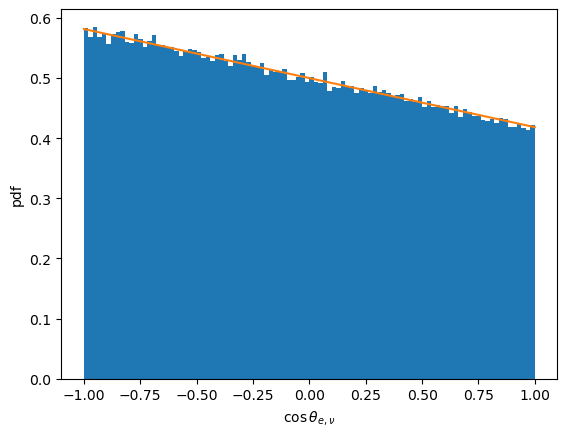

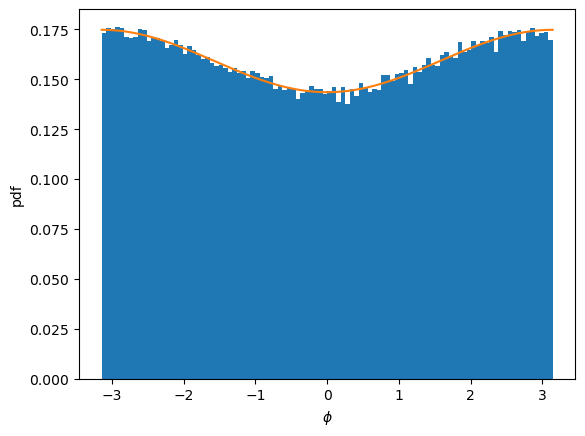

7 0.016 0.9168014534047305 0.17111994178018536 0.01919598144581948


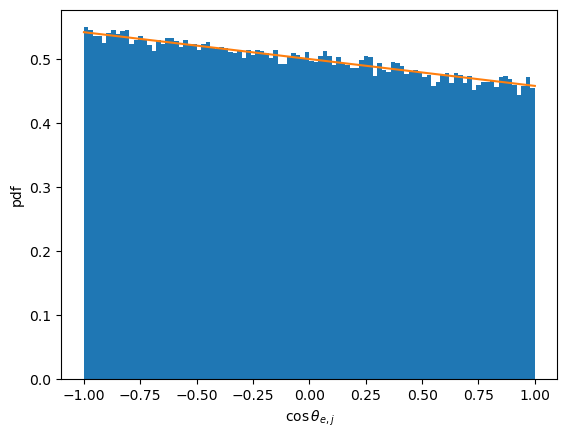

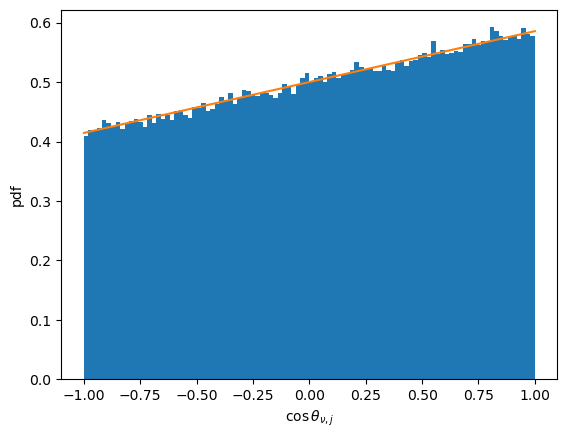

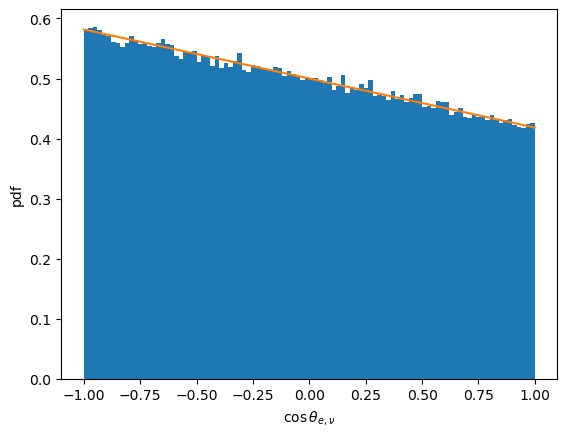

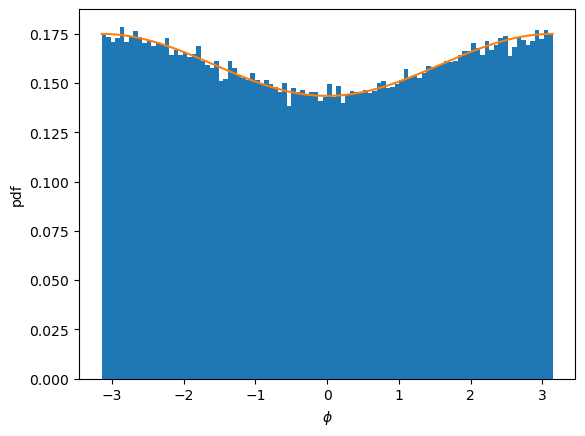

8 0.018000000000000002 0.9256928882251768 0.15258509322588532 0.015235949578744289


/tmp/ipykernel_422760/781026101.py:5: UserWarning: genfromtxt: Empty input file: "build/60Co_polZWu9.txt"
  data = np.genfromtxt(fileName, dtype=str)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [18]:
for i in range(10):
    def SM_coeffs(E):
        return (-1/3, 0, align_list[i], -1*polz_list[i], polz_list[i], 0)
    print(i,T[i],np.exp(-mu_60Co*B/kb/T[i]),polz_list[i],align_list[i])
    
    SM_60Co_polZpos = Co60_data_analysis(f"build/60Co_polZWu{i+1}.txt")
    SM_60Co_polZpos.event_mask()
    SM_60Co_polZpos.kinematical_data()
    SM_60Co_polZpos.kinematical_data_ref()
    SM_60Co_polZpos.theoretical_dist(SM_coeffs)
    SM_60Co_polZpos.plot_distribution_histograms(showTheory=True,bins=100)